# Analysing the Dataset
 

In this notebook, we analyze the data set to subsequently test our stated hypothesis. For the visualizations we use the library ```geopandas```.


## Imports

First, the necessary libraries are imported and the default setting for the library ```tueplots``` is set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas
from sklearn.linear_model import LinearRegression
from tueplots import bundles

# Settings for tueplots
plt.rcParams.update(bundles.neurips2021(usetex=False))

## Preparing the dataset
In this section, the data sets are loaded and prepared to perform the analysis afterwards.

The data set ```salary_data``` contains the country codes in the format ISO 3166-1 alpha-2 (two-digit country code) whereas ```geopandas``` contains the format ISO 3166-1 alpha-3 (three-digit country code). For this reason the data set must be prepared to be used with geopandas.

In [2]:
# Load all datasets
salary_data = pd.read_csv('..\data\salaries.csv') # available at: https://salaries.freshremote.work/download/
country_codes = pd.read_csv('..\data\codes.csv') # this dataset is made by our own, its uploaded in the git repro
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

codes = country_codes.rename(columns={"Alpha-2 code":"country_code","Alpha-3 code":"iso_a3"})

In [3]:
# This function prepares the data so it can be used by geopandas
def join_world_data(df):
    df = pd.merge(df,country_codes,on="country_code")
    df = pd.merge(df,world,on="iso_a3",how="outer")
    df = df.drop(columns=['iso_a3','pop_est','continent','gdp_md_est'])
    return df

# Analyse the data
This section now analyzes the data. First, let's look at the countries where workers reside.

To do this we first define a function that displays the data using ```geopandas```.

In [4]:
# This function is used to plot the data on a world map
def plot_geo(df, column, label):
    data_geo = geopandas.GeoDataFrame(df)

    fig, ax = plt.subplots()
    data_geo.plot(column = column,
                  missing_kwds = {'color':'lightgrey'},
                  cmap = 'Blues',
                  ax = ax,
                  legend = True,
                  legend_kwds = {'label': label ,'orientation': "horizontal"})
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [5]:
# Preparing the data by filtering for the employee residence and counting the rows
residence_data = salary_data.filter(items=["employee_residence"])
residence_data = residence_data.rename(columns={"employee_residence":"country_code"})
residence_data["number"] = 1
residence_world_data = join_world_data(residence_data)
residence_world_data = residence_world_data.groupby(['name']).agg({'country_code':'first','geometry':'first','number':'sum'}).reset_index()
residence_world_data.number = np.where(residence_world_data.number == 0, np.nan, residence_world_data.number)

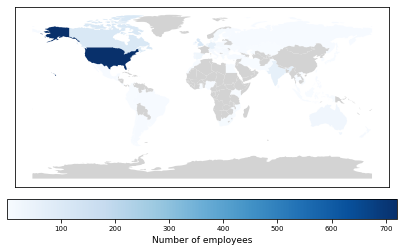

In [6]:
# Plot the data and save the figure
plot_geo(residence_world_data, 'number', 'Number of employees')
plt.savefig('../doc/fig/world_employee_residence.pdf',bbox_inches='tight')

In [7]:
# Calculate the percentage of employees who live in the USA
residence_usa_data = residence_world_data[residence_world_data.country_code == 'US']
percentage = round(residence_usa_data.number.sum()/residence_world_data.number.sum()*100,2)
print('Percentage of employees who live in the USA: '+ str(percentage)+'%')

Percentage of employees who live in the USA: 49.86%


As you can see, almost half of the people live in the US. For this reason, we want to look at where people work in the next step.

In [8]:
# Preparing the data by filtering for the company location and counting the rows
location_data = salary_data.filter(items=["company_location"])
location_data = location_data.rename(columns={"company_location":"country_code"})
location_data["number"] = 1
location_world_data = join_world_data(location_data)
location_world_data = location_world_data.groupby(['name']).agg({'country_code':'first','geometry':'first','number':'sum'}).reset_index()
location_world_data.number = np.where(location_world_data.number == 0, np.nan, location_world_data.number)

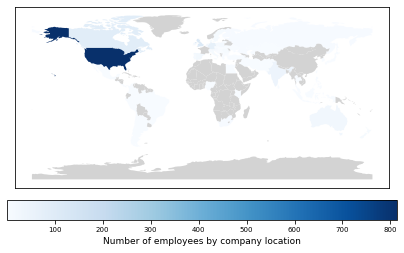

In [9]:
# plot the data
plot_geo(location_world_data, 'number', 'Number of employees by company location')

In [10]:
# Calculate the percentage of employees who live and also work in the USA
location_usa_data = location_world_data[location_world_data.country_code == 'US']
percentage = round(residence_usa_data.number.sum()/location_usa_data.number.sum()*100,2)
print('Percentage of employees who work and live in the USA: '+ str(percentage)+'%')

Percentage of employees who work and live in the USA: 88.57%


Our next goal is to analyze how much is earned on average in which country. For this we filter again by ```employee_residence``` and by ```company_location```.

In [11]:
# Preparing the data by computing the mean salary per country by company location 
salary_location_data = salary_data.filter(items=["salary_in_usd","company_location"])
salary_location_data = salary_location_data.rename(columns={"salary_in_usd":"salary","company_location":"country_code"})
# filtering out the outliers                                        
salary_location_data = salary_location_data.drop(salary_location_data[salary_location_data.salary > salary_location_data.salary.mean()].index)
salary_location_world_data = join_world_data(salary_location_data)
salary_location_world_data = salary_location_world_data.groupby(['name']).agg({'country_code':'first','geometry':'first','salary':'mean'}).reset_index()

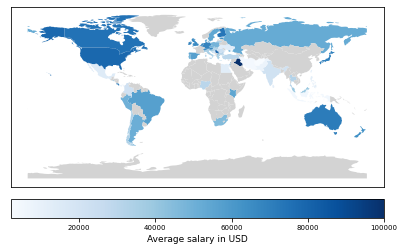

In [12]:
# Plot the data and save the figure
plot_geo(salary_location_world_data, 'salary','Average salary in USD')
plt.savefig('../doc/fig/world_salary_company_location.pdf',bbox_inches='tight')

In [13]:
# Preparing the data by computing the mean salary per country by employee residence
salary_residence_data = salary_data.filter(items=["salary_in_usd","employee_residence"])
salary_residence_data = salary_residence_data.rename(columns={"salary_in_usd":"salary","employee_residence":"country_code"})
# filtering out the outliers
salary_residence_data = salary_residence_data.drop(salary_residence_data[salary_residence_data.salary > salary_residence_data.salary.mean()].index)
salary_residence_world_data = join_world_data(salary_residence_data )
salary_residence_world_data = salary_residence_world_data .groupby(['name']).agg({'country_code':'first','geometry':'first','salary':'mean'}).reset_index()

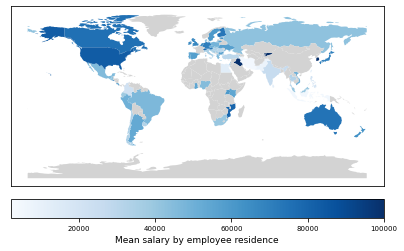

In [14]:
# Plot the data
plot_geo(salary_residence_world_data, 'salary', 'Mean salary by employee residence')

As you can see, the two plots hardly differ from each other.

# Regression
In this section, we try to find a correlation between ```company_size``` and ```salary``` using one-hot encoding.

In [15]:
def add_one_hot_encoding(df, new_column_name, condition_column, condition_value, if_value, else_value):
    df[new_column_name] = np.where(df[condition_column] == condition_value, if_value, else_value)

In [16]:
company_size_salary_data = salary_data.filter(items=["salary_in_usd","company_size"])
company_size_salary_data = company_size_salary_data.rename(columns={"salary_in_usd":"salary"})
add_one_hot_encoding(company_size_salary_data, 'company_s', 'company_size', 'S', 1, 0)
add_one_hot_encoding(company_size_salary_data, 'company_m', 'company_size', 'M', 1, 0)
add_one_hot_encoding(company_size_salary_data, 'company_l', 'company_size', 'L', 1, 0)
y = company_size_salary_data.drop(columns=["company_size","company_s","company_m","company_l"])
X = company_size_salary_data.drop(columns=["company_size","salary"])

reg = LinearRegression()
reg.fit(X,y)
reg.coef_

array([[-12474.72464334,    555.86437373,  11918.86026961]])